# Graficas para visualizador

In [8]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import plotly.express as px
from covid_xprize.standard_predictor.xprize_predictor import NPI_COLUMNS
from covid_xprize.scoring.prescriptor_scoring import weight_prescriptions_by_cost
from covid_xprize.scoring.prescriptor_scoring import generate_cases_and_stringency_for_prescriptions
from covid_xprize.scoring.prescriptor_scoring import compute_domination_df
from covid_xprize.scoring.prescriptor_scoring import compute_pareto_set
from covid_xprize.validation.prescriptor_validation import validate_submission

from covid_xprize.scoring.predictor_scoring import load_dataset
from covid_xprize.validation.scenario_generator import generate_scenario

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def plot_pareto_curve(objective1_list, objective2_list):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    plt.plot(xs, ys)

## Reproducir gráfica del pareto para un sólo país

En esta celda hacemos todos los cálculos

In [4]:
# define inicio y fin para las prescripciones
START_DATE = "2020-08-01"
END_DATE = "2020-08-05"
# Trae los últmos datos y filtra con los paises de la competencia
LATEST_DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
GEO_FILE = "countries_regions.csv"
latest_df = load_dataset(LATEST_DATA_URL, GEO_FILE)
# genera y guarda un escenario de prueba
IP_FILE = "prescriptions/robojudge_test_scenario.csv"
countries = ["Mexico"]
scenario_df = generate_scenario(START_DATE, END_DATE, latest_df, countries, scenario="Freeze")
scenario_df.to_csv(IP_FILE, index=False)
# Cost weightings for each IP for each geo
TEST_COST = "covid_xprize/validation/data/uniform_random_costs.csv"
# Generate some random prescriptions
for i in range(2):
    output_file = "covid_xprize/examples/prescriptors/random/prescriptions/random_presc_"+ str(i+1) +".csv"
    !python covid_xprize/examples/prescriptors/random/prescribe.py -s {START_DATE} \
                                                                   -e {END_DATE} \
                                                                   -ip {IP_FILE} \
                                                                   -c {TEST_COST} \
                                                                   -o {output_file}
# Generate blind_greedy prescriptions
output_file = "covid_xprize/examples/prescriptors/blind_greedy/prescriptions/blind_greedy.csv"
!python covid_xprize/examples/prescriptors/blind_greedy/prescribe.py -s {START_DATE} \
                                                                     -e {END_DATE} \
                                                                     -ip {IP_FILE} \
                                                                     -c {TEST_COST} \
                                                                     -o {output_file}
# Diccionario de archivos con las prescripciones                                                                     
prescription_files = {
    'Random1': 'covid_xprize/examples/prescriptors/random/prescriptions/random_presc_1.csv',
    'Random2': 'covid_xprize/examples/prescriptors/random/prescriptions/random_presc_2.csv',
    'BlindGreedy': 'covid_xprize/examples/prescriptors/blind_greedy/prescriptions/blind_greedy.csv',
}
# Collect case and stringency data for all prescriptors
dfs = []
for prescriptor_name, prescription_file in sorted(prescription_files.items()):
    print("Generating predictions for", prescriptor_name)
    df, _ = generate_cases_and_stringency_for_prescriptions(START_DATE, END_DATE, prescription_file, TEST_COST)
    df['PrescriptorName'] = prescriptor_name
    dfs.append(df)
df = pd.concat(dfs)

Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!
Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!
Generating prescriptions from 2020-08-01 to 2020-08-05...
Done!
Generating predictions for BlindGreedy
Generated predictions for PrescriptionIndex 0
Generated predictions for PrescriptionIndex 1
Generated predictions for PrescriptionIndex 2
Generated predictions for PrescriptionIndex 3
Generated predictions for PrescriptionIndex 4
Generated predictions for PrescriptionIndex 5
Generated predictions for PrescriptionIndex 6
Generated predictions for PrescriptionIndex 7
Generated predictions for PrescriptionIndex 8
Generated predictions for PrescriptionIndex 9
Evaluated 10 PrescriptionIndex in 00:00:04 seconds
Generating predictions for Random1
Generated predictions for PrescriptionIndex 0
Generated predictions for PrescriptionIndex 1
Generated predictions for PrescriptionIndex 2
Generated predictions for PrescriptionIndex 3
Generated predictions for PrescriptionI

La gráfica tal como viene en el robojudge

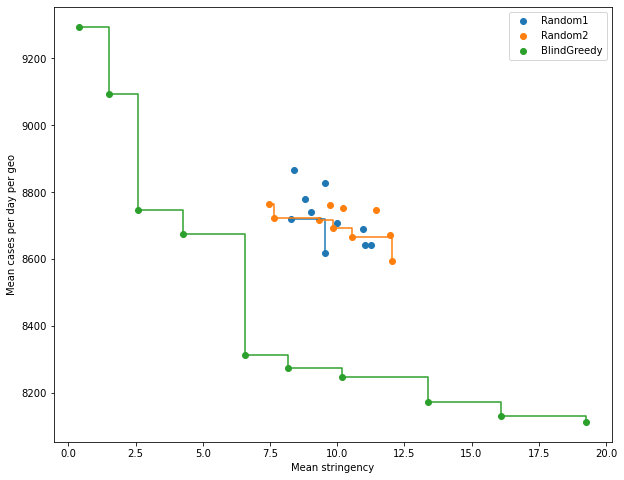

In [19]:
# Plot overall stringency and cases of each prescription
plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = df[df['PrescriptorName'] == prescriptor_name]
    overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(overall_pdf['Stringency'],
                overall_pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
    plot_pareto_curve(list(overall_pdf['Stringency']),
                      list(overall_pdf['PredictedDailyNewCases']))
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.legend()
plt.show()

Ahora tenemos que reproducir la gráfica con plotly. Empecemos con el scatter

In [6]:
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [25]:
import plotly.express as px
pdf = df[df['PrescriptorName'] == 'Random1']
overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
fig = px.scatter(overall_pdf, x='Stringency', y='PredictedDailyNewCases')
fig.show()

Reescribimos la función que grafica el pareto

In [21]:
def plot_pareto_curve_ply(objective1_list, objective2_list):
    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    fig = px.line(x=xs, y=ys)
    return fig

In [22]:
fig = plot_pareto_curve_ply(list(overall_pdf['Stringency']),
                    list(overall_pdf['PredictedDailyNewCases']))
fig.show()

Ahora ¿cómo ponemos las dos en la misma figura?

Tenmos que modificar la función que regresa la gráfica de pareto para que regrese el trace en lugar de la figura, además necesita aceptar un color como argumento

In [5]:
def plot_pareto_curve_ply(objective1_list, objective2_list, color="red"):

    """
    Plot the pareto curve given the objective values for a set of solutions.
    This curve indicates the area dominated by the solution set, i.e., 
    every point up and to the right is dominated.
    """
    
    # Compute pareto set from full solution set.
    objective1_pareto, objective2_pareto = compute_pareto_set(objective1_list, 
                                                              objective2_list)
    
    # Sort by first objective.
    objective1_pareto, objective2_pareto = list(zip(*sorted(zip(objective1_pareto,
                                                                objective2_pareto))))
    
    # Compute the coordinates to plot.
    xs = []
    ys = []
    
    xs.append(objective1_pareto[0])
    ys.append(objective2_pareto[0])
    
    for i in range(0, len(objective1_pareto)-1):
        
        # Add intermediate point between successive solutions
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i])
        
        # Add next solution on front
        xs.append(objective1_pareto[i+1])
        ys.append(objective2_pareto[i+1])
        
    df = pd.DataFrame([xs, ys]).T
    df.columns = ["Stringency", 'PredictedDailyNewCases']
    return px.line(df, x="Stringency", y='PredictedDailyNewCases', color_discrete_sequence=[color])

In [2]:

fig = px.scatter(overall_pdf, x='Stringency', y='PredictedDailyNewCases')
pareto = plot_pareto_curve_ply(list(overall_pdf['Stringency']),
                    list(overall_pdf['PredictedDailyNewCases']))
fig.add_trace(pareto.data[0])
fig.show()

NameError: name 'px' is not defined

Conjuntando todo

In [9]:
# Plot overall stringency and cases of each prescription
import palettable as pltt
paleta = pltt.tableau.BlueRed_6.hex_colors
for i, prescriptor_name in enumerate(prescription_files):
    pdf = df[df['PrescriptorName'] == prescriptor_name]
    overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    if i==0:
        fig = px.scatter(overall_pdf, x='Stringency', y='PredictedDailyNewCases',
                    color_discrete_sequence=[paleta[i]])
        fig.data[-1].name = prescriptor_name
        fig.data[-1].showlegend = True
    else:
        fig.add_trace(px.scatter(overall_pdf, x='Stringency', y='PredictedDailyNewCases',
                    color_discrete_sequence=[paleta[i]]).data[0])
        fig.data[-1].name = prescriptor_name
        fig.data[-1].showlegend = True
    pareto = plot_pareto_curve_ply(list(overall_pdf['Stringency']),
                    list(overall_pdf['PredictedDailyNewCases']), color=paleta[i])
    fig.add_trace(pareto.data[0])
fig.show()

In [39]:
for i,j in enumerate(prescription_files):
    print(i,j)

0 Random1
1 Random2
2 BlindGreedy


In [38]:
prescription_files

{'Random1': 'covid_xprize/examples/prescriptors/random/prescriptions/random_presc_1.csv',
 'Random2': 'covid_xprize/examples/prescriptors/random/prescriptions/random_presc_2.csv',
 'BlindGreedy': 'covid_xprize/examples/prescriptors/blind_greedy/prescriptions/blind_greedy.csv'}